In [18]:
# get the required table from wikipedia
import pandas as pd
import numpy as np
import requests
from pandas import ExcelWriter
from pandas import ExcelFile
'''
The school data comes from http://ontario.compareschoolrankings.org/elementary/SchoolsByRankLocationName.aspx
due to the nature of this site, the data was converted to a csv file before uploading.
'''

schools_df = pd.read_excel('schools.xlsx')
split = schools_df['2017-18 Rank'].str.split("/", n=1, expand=True)

split[0].replace('','0', inplace=True)

split[0].fillna(split[0].mean())
split[0] = split[0].astype(int)

schools_df['Rank/3046'] = split[0]
schools_df.drop(columns=['2017-18 Rank'], axis=1, inplace=True)

schools_df['2017-18 Rating'] = schools_df['2017-18 Rating'].astype(float)

schools_df.head()

,School Name,City,2017-18 Rating,Rank/3046
0,Abraham Erb,Waterloo,8.5,144
1,Laurelwood,Waterloo,8.2,213
2,Our Lady of Lourdes,Waterloo,7.9,334
3,Millen Woods,Waterloo,7.8,388
4,Lexington,Waterloo,7.5,559


In [19]:
schools_df.describe(include='all')

,School Name,City,2017-18 Rating,Rank/3046
count,81,81,81.000000,81.000000
unique,81,2,NaN,NaN
top,Howard Robertson,Kitchener,NaN,NaN
freq,1,54,NaN,NaN
mean,NaN,NaN,6.023457,1497.580247
std,NaN,NaN,1.414768,824.524907
min,NaN,NaN,2.300000,0.000000
25%,NaN,NaN,5.100000,740.000000
50%,NaN,NaN,6.200000,1470.000000
75%,NaN,NaN,7.200000,2210.000000


In [20]:
schools_df.shape

(81, 4)

### Clean the school data and add latutude and longitude coordinates

In [21]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_school_dat")

coords = []

for ind, row in schools_df.iterrows():
    loc_str1 = row[0] + ' Public School, ' + row[1] # find and get coordinates for public schools
    loc_str2 = row[0] + ', ' + row[1] # attempt to find and get coordinates for Catholic and independent schools
    location = geolocator.geocode(loc_str1)
    if location:
        coords.append([row[0],location.latitude, location.longitude])
    else:
        location = geolocator.geocode(loc_str2)
        if  location:
            coords.append([row[0],location.latitude, location.longitude])

coords_df = pd.DataFrame(coords)


In [22]:
coords_df.shape

(69, 3)

In [23]:
coords_df.dropna(inplace=True) # remove any schools without coordinates
coords_df.shape

(69, 3)

In [24]:
# clean-up the dataframe, add labels
coords_df.rename(columns={0:'School Name',1:'Latitude',2:'Longitude'}, inplace=True)
coords_df.head(10)

,School Name,Latitude,Longitude
0,Abraham Erb,43.470070,-80.597760
1,Laurelwood,43.469265,-80.574892
2,Our Lady of Lourdes,43.458840,-80.531052
3,Millen Woods,43.513493,-80.504685
4,Lexington,43.501287,-80.496724
5,St Nicholas,42.506569,-92.305409
6,Mère-Élisabeth-Bruyère,43.483415,-80.510190
7,Elizabeth Ziegler,43.465247,-80.511895
8,Mary Johnston,43.458490,-80.563629
9,Northlake Woods,43.496372,-80.564813


In [26]:
schools_df.head(3)

,School Name,City,2017-18 Rating,Rank/3046
0,Abraham Erb,Waterloo,8.5,144
1,Laurelwood,Waterloo,8.2,213
2,Our Lady of Lourdes,Waterloo,7.9,334


In [27]:
# Add coordinate information to the schools_df
schools_df = schools_df.join(coords_df.set_index('School Name'), on='School Name')

In [28]:
schools_df.dropna(inplace=True)
schools_df.head()

,School Name,City,2017-18 Rating,Rank/3046,Latitude,Longitude
0,Abraham Erb,Waterloo,8.5,144,43.470070,-80.597760
1,Laurelwood,Waterloo,8.2,213,43.469265,-80.574892
2,Our Lady of Lourdes,Waterloo,7.9,334,43.458840,-80.531052
3,Millen Woods,Waterloo,7.8,388,43.513493,-80.504685
4,Lexington,Waterloo,7.5,559,43.501287,-80.496724


In [29]:
# save data to csv for easier import in future
schools_df.to_csv(r'schools_data.csv')

### Data can now be imported for use in other notebooks, and to avoid the time it take to rerun the extractions each session

In [30]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Waterloo, Ontario, Canada'  # base of map

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
# get coordinated for Waterloo city center and print the results
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Waterloo are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Waterloo are 43.466874, -80.524635.


In [31]:
import folium # map rendering library

# create map of Waterloo using latitude and longitude values
map_KW = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markersfor the identified schools to map from the schools_df data
for lat, lng, school, city in zip(schools_df['Latitude'], schools_df['Longitude'], schools_df['School Name'], schools_df['City']):
    label = '{}; {}'.format(school, city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_KW)  
    
map_KW

In [32]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

CLIENT_ID = '443E05IF1V3S2NAHVOA0CIDJGJQ1NNZZ2MH14NYFVXBGGG2K' # your Foursquare ID
CLIENT_SECRET = 'S13WDCLFB4JU44WNKX2ANWFXQGQGB0JXT4AOKZCW0AE0ZZ54' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# What can we learn about similar neighbourhoods when schools are considered the hub of neighbourhoods?

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            50)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [33]:
#get a subset of venues for KW sities around schools
KW_df = schools_df

# get the nearby venues for the schools
schools_venues = getNearbyVenues(names=KW_df['School Name'],
                                   latitudes=KW_df['Latitude'],
                                   longitudes=KW_df['Longitude']
                                  )

Abraham Erb
Laurelwood
Our Lady of Lourdes
Millen Woods
Lexington
St Nicholas
Mère-Élisabeth-Bruyère
Elizabeth Ziegler
Mary Johnston
Northlake Woods
St Luke
Vista Hills
Empire
N A MacEachern
St Matthew
Lester B Pearson
St Agnes
Holy Rosary
L'Harmonie
Westvale
Edna Staebler
Winston Churchill
Sir Edgar Bauer
Sandowne
Keatsway
Cedarbrae
Lincoln Heights
Lackner Woods
Williamsburg
Alpine
Brigadoon
J W Gerth
Bridgeport
Sheppard
Smithson
MacKenzie King
John Sweeney
Sandhills
St Aloysius
Jean Steckle
Blessed Sacrament
Cardinal-Léger
Canadian Martyrs
Groh
W.T. Townshend
Glencairn
Crestview
St John
Pioneer Park
Franklin
John Darling
Westmount
Driftwood Park
Suddaby
Chicopee Hills
Southridge
Meadowlane
Trillium
Wilson Avenue
Monsignor Haller
Forest Hill
Howard Robertson
Prueter
Queen Elizabeth
Rockway
Country Hills
J F Carmichael
King Edward
A R Kaufman


In [34]:
print(f"There are {schools_venues.shape[0]} total venues in Kitchener-Waterloo and {schools_venues['Venue Category'].nunique()} unique venue categories.")

There are 1337 total venues in Kitchener-Waterloo and 211 unique venue categories.


In [35]:
schools_venues.head(2)  # Check the data with Scarborough filter

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abraham Erb,43.47007,-80.59776,Wild Wing,43.472607,-80.59456,Wings Joint
1,Abraham Erb,43.47007,-80.59776,Dairy Queen,43.472373,-80.59271,Fast Food Restaurant


In [36]:
# 1337 KW venues with 211 unique categories

# one hot encoding
schools_onehot = pd.get_dummies(schools_venues[['Venue Category']], prefix="", prefix_sep="")

# add school name column back to dataframe
schools_onehot['School Name'] = schools_venues['Neighborhood'] 

schools_onehot.shape

(1337, 212)

In [37]:
# move School Name column to the first column
fixed_columns = [schools_onehot.columns[-1]] + list(schools_onehot.columns[:-1])
schools_onehot = schools_onehot[fixed_columns]

schools_onehot.head()

,School Name,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Abraham Erb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Abraham Erb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abraham Erb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abraham Erb,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abraham Erb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# group by the onehot Neighbourhood, averaging the results to create an weighted value for each Venue Category
schools_grouped = schools_onehot.groupby('School Name').mean().reset_index()
schools_grouped.head()

,School Name,Accessories Store,African Restaurant,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,A R Kaufman,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abraham Erb,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0
2,Alpine,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,...,0.0,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Blessed Sacrament,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bridgeport,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
schools_grouped.shape
# check the shape of the data frame (expecting 16 boroughs in scarborough with 53 venue categories)

(68, 212)

In [40]:
# create a function that will sort the top venues for each neighborhood submitted in a data frame

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
import numpy as np
num_top_venues = 5  # get the 5 most popular venues for each neighbourhood

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['School Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
schools_venues_sorted = pd.DataFrame(columns=columns)
schools_venues_sorted['School Name'] = schools_grouped['School Name']

for ind in np.arange(schools_grouped.shape[0]):
    schools_venues_sorted.iloc[ind, 1:] = return_most_common_venues(schools_grouped.iloc[ind, :], num_top_venues)

schools_venues_sorted.head()

,School Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,A R Kaufman,Pizza Place,Bakery,Grocery Store,Paintball Field,Furniture / Home Store
1,Abraham Erb,Park,Fast Food Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant
2,Alpine,Convenience Store,Shopping Mall,Fast Food Restaurant,Pizza Place,Coffee Shop
3,Blessed Sacrament,Convenience Store,Bank,Park,Sandwich Place,Kids Store
4,Bridgeport,Coffee Shop,Sandwich Place,Mediterranean Restaurant,BBQ Joint,Supermarket


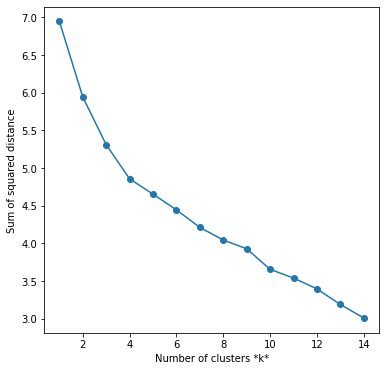

In [45]:
import matplotlib.pyplot as plt

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 15))
#remove name so not considered in clustering
schools_grouped_clustering = schools_grouped.drop('School Name', 1)

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(schools_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [46]:
# set number of clusters I experiemented with 3 through 10 selecting 7 as the best number of clusters (most differentiation)
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(schools_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 3, 3, 0, 0, 0, 3, 0, 0], dtype=int32)

In [47]:
# add clustering labels

schools_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

schools_merged = schools_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
schools_merged = schools_merged.join(schools_venues_sorted.set_index('School Name'), on='School Name')

schools_merged.head() # check the dataframe

,School Name,City,2017-18 Rating,Rank/3046,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abraham Erb,Waterloo,8.5,144,43.470070,-80.597760,2.0,Park,Fast Food Restaurant,Pharmacy,Sandwich Place,Chinese Restaurant
1,Laurelwood,Waterloo,8.2,213,43.469265,-80.574892,0.0,Chinese Restaurant,Bank,Gym / Fitness Center,Sandwich Place,Grocery Store
2,Our Lady of Lourdes,Waterloo,7.9,334,43.458840,-80.531052,0.0,Restaurant,Coffee Shop,Shopping Mall,Café,Gastropub
3,Millen Woods,Waterloo,7.8,388,43.513493,-80.504685,0.0,Restaurant,Gym / Fitness Center,Athletics & Sports,Soccer Field,Skating Rink
4,Lexington,Waterloo,7.5,559,43.501287,-80.496724,0.0,Candy Store,Bar,Pizza Place,Nature Preserve,Park


In [48]:
#toronto_merged = toronto_merged[[toronto_merged['Cluster Labels'] != 'nan']]
schools_merged['Cluster Labels'].replace([np.inf, -np.inf], np.nan)
schools_merged['Cluster Labels'].fillna(0, inplace=True)
schools_merged['Cluster Labels'] = schools_merged['Cluster Labels'].astype(int)
schools_merged['Cluster Labels'].value_counts()
# check to see how many of each cluster

0    38
3    23
2     7
1     1
Name: Cluster Labels, dtype: int64

In [49]:
address = 'Waterloo, Ontario, Canada'  # base of map

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
# get coordinated for Scarborough city center and print the results
latitude = location.latitude
longitude = location.longitude

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create the KW map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set colors for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rank in zip(schools_merged['Latitude'], schools_merged['Longitude'], schools_merged['School Name'], schools_merged['Cluster Labels'], schools_merged['2017-18 Rating']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Rating: ' + str(rank), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save("schools.jpg")
map_clusters

##### Noticings: 
### The School Communities in the centre of KW (closer to downtown) are very similar neighbourhoods.  The neighbourhoods become more differentiated the further you move away from the city core.
<img src="schools_map.png">